<a href="https://colab.research.google.com/github/dsoftcorp/MercadosML/blob/main/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error


from scipy import stats
from sklearn.linear_model import LinearRegression
import plotly.express as px
import folium


In [149]:
# Definicion de funciones
#######################################################################
#  FUNCIONES DE METRICA
#######################################################################
def calcularAccuracy(TP, TN, FP, FN):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy * 100
    return accuracy.round(2)

def calcularSensibilidad(TP, TN, FP, FN):
    sensibilidad = TP / (TP + FN)
    sensibilidad = sensibilidad * 100
    return sensibilidad.round(2)

def calcularEspecificidad(TP, TN, FP, FN):
    especificidad = TN / (TN + FP)
    especificidad = especificidad * 100
    return especificidad.round(2)

def matconf(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3,3));
    ax = plt.axes();
    sns.heatmap(cm,annot=True,fmt="6",ax=ax,linewidths=4,cbar_kws={'label': 'Total de muestras', 'orientation': 'horizontal'});
    ax.set_title("Matriz de Confusion");  
    return cm   

def scores(y_test,y_pred):  
    cm = matconf(y_test,y_pred)
    (TN, FP, FN, TP) = cm.ravel()
    print("True positives: "+str(TP))
    print("True negatives: "+str(TN))
    print("False positives: "+str(FP))
    print("False negative: "+str(FN))
    acc = calcularAccuracy(TP, TN, FP, FN)
    sen = calcularSensibilidad(TP, TN, FP, FN)
    spec = calcularEspecificidad(TP, TN, FP, FN)
    print("Precision:"+str(acc)+"%")
    print("Sensibilidad:"+str(sen)+"%")
    print("Especificidad:"+str(spec)+"%")
    return acc

def estadisticos(df,var):
    print(f'La media de la variable {var} es {df[var].mean():.2f}')
    print(f'La media truncada de la variable {var} con 0.1 de margen es {stats.trim_mean(df[var],0.1):.2f}')
    print(f'La desviacion estandar de la variable {var} es {df[var].std():.2f}')
    print(f'El rango de la variable {var} es {df[var].max()-df[var].min()}')
    df4 = df[df[var]>0]
    print(f'El 1er cuartil de la variable {var} es {df4[var].quantile(0.25):.2f}')
    print(f'El 3er cuartil de la variable {var} es {df4[var].quantile(0.75):.2f}')
    print(f'IQR de la variable {var} es {df4[var].quantile(0.75)-df4[var].quantile(0.25):.2f}')

def filtrar(df, valor):
    df = df[df[valor]>0]
    iqr = df[valor].quantile(0.75) - df[valor].quantile(0.25)
    filtro_inferior = df[valor] > df[valor].quantile(0.25) - (iqr * 1.5)
    filtro_superior = df[valor] < df[valor].quantile(0.75) + (iqr * 1.5)
    df_filtrado = df[filtro_inferior & filtro_superior]
    return df_filtrado

def modificar(df, var):
    varS = "Hra"+var+"_S"
    varF = "Hra"+var+"_F"
    varmS = "Min"+var+"_S"
    varmF = "Min"+var+"_F"
    df[varmS] = df[varmS]/60
    df[varmF] = df[varmF]/60
    df[varS] = df[varS] + df[varmS].round(2)
    df[varF] = df[varF] + df[varmF].round(2)
    df.drop([varmS,varmF],axis=1,inplace=True)
    print("Listo")
    return df

def predecir(opciones):
  prediccion = modelo_nn.predict([opciones])
  if prediccion == 1:
    print("La persona o grupo en cuestión SI se interesaría en cursar estudios en una Institución de Enseñanza Superior")
  else:
    print("La persona o grupo en cuestión NO se interesaría en cursar estudios en una Institución de Enseñanza Superior")

# <h2>Normalización y limpieza de datos</h2>

Importamos archivo de seccion de datos abiertos de INEGI

In [ ]:
import requests

url = "https://www.inegi.org.mx/contenidos/programas/enut/2019/datosabiertos/conjunto_de_datos_enut_2019_csv.zip"
myfile = requests.get(url, allow_redirects=True)

open('d:/hello.zip', 'wb').write(myfile.content)


17980198

Una vez extraidos los archivos, usamos el dataframe con los datos raw del archivo csv desempacado

In [2]:
df = pd.read_csv("/content/drive/MyDrive/BEDUPrototype/enut_2019.csv",index_col=0)

Damos una primera vista a los datos

In [3]:
df.head()

,VIV_SEL,HOGAR,N_REN,ENT,SEXO,EDAD_V,P4_1,P4_1C,P4_2,NIV,GRA,P4_4,P4_5,P4_6,P5_1,P5_2,P5_3_1,P5_3_2,P5_3_3,P5_3_4,P5_4_1,P5_4_2,P5_4_3,P5_4_4,P5_5,P5_6_1,P5_6_2,P5_6_3,P5_6_4,P5_6_5,P5_6_6,P5_6_7,P5_7,P5_7A,P5_8,P5_9_1,P5_9_2,P5_9_3,P5_9_4,P6_1_1_1,...,P6_22_5,P6_22A_5_1,P6_22A_5_2,P6_22A_5_3,P6_22A_5_4,P6_23_1,P6_23A_1_1,P6_23A_1_2,P6_23A_1_3,P6_23A_1_4,P6_23_2,P6_23A_2_1,P6_23A_2_2,P6_23A_2_3,P6_23A_2_4,P6_23_3,P6_23_3C,P6_23A_3_1,P6_23A_3_2,P6_23A_3_3,P6_23A_3_4,P7_1_1,P7_1_2,P7_1_3,P7_1_4,P7_1_5,P7_1_6,P7_1_7,P7_1_8,P7_2_1,P7_2_2,P7_2_3,P7_2_4,P7_2_5,P7_2_6,P7_3,TLOC,EST_DIS,UPM_DIS,FAC_PER
UPM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,2,88,2,NaN,1,2,3,4,2,NaN,2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,55,...,2,NaN,NaN,NaN,NaN,1,5.0,0.0,4.0,0.0,1,3.0,0.0,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,2,8,8,8,8,8,8,3,3,4,3,3,3,3,3,1,2,1,465
1,2,1,1,1,2,64,2,NaN,1,2,6,4,2,NaN,2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,40,...,2,NaN,NaN,NaN,NaN,1,5.0,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,8,8,8,3,8,8,3,2,3,3,4,1,1,3,1,2,1,465
1,2,1,2,1,1,30,2,NaN,1,6,3,6,2,NaN,1,NaN,40.0,0.0,20.0,0.0,1.0,20.0,0.0,40.0,1.0,1.0,1.0,1.0,9.0,9.0,1.0,2.0,8300.0,3.0,NaN,NaN,NaN,NaN,NaN,40,...,1,4.0,0.0,1.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,8,8,1,8,3,2,1,3,5,5,4,4,4,4,4,1,2,1,472
1,2,1,3,1,1,25,2,NaN,1,3,3,6,2,NaN,1,NaN,55.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,9.0,1.0,2.0,4000.0,2.0,NaN,NaN,NaN,NaN,NaN,40,...,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,8,2,8,8,2,8,2,4,4,4,4,4,4,4,1,2,1,472
1,2,1,4,1,2,22,2,NaN,1,8,2,6,2,NaN,1,NaN,22.0,0.0,18.0,0.0,0.0,50.0,0.0,20.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,40,...,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,2,2,8,3,2,8,2,4,4,3,4,3,4,4,1,2,1,465


In [4]:
df.describe()

,VIV_SEL,HOGAR,N_REN,ENT,SEXO,EDAD_V,P4_1,P4_1C,P4_2,NIV,GRA,P4_4,P4_5,P4_6,P5_1,P5_2,P5_3_1,P5_3_2,P5_3_3,P5_3_4,P5_4_1,P5_4_2,P5_4_3,P5_4_4,P5_5,P5_6_1,P5_6_2,P5_6_3,P5_6_4,P5_6_5,P5_6_6,P5_6_7,P5_7,P5_7A,P5_8,P5_9_1,P5_9_2,P5_9_3,P5_9_4,P6_1_1_1,...,P6_22_5,P6_22A_5_1,P6_22A_5_2,P6_22A_5_3,P6_22A_5_4,P6_23_1,P6_23A_1_1,P6_23A_1_2,P6_23A_1_3,P6_23A_1_4,P6_23_2,P6_23A_2_1,P6_23A_2_2,P6_23A_2_3,P6_23A_2_4,P6_23_3,P6_23_3C,P6_23A_3_1,P6_23A_3_2,P6_23A_3_3,P6_23A_3_4,P7_1_1,P7_1_2,P7_1_3,P7_1_4,P7_1_5,P7_1_6,P7_1_7,P7_1_8,P7_2_1,P7_2_2,P7_2_3,P7_2_4,P7_2_5,P7_2_6,P7_3,TLOC,EST_DIS,UPM_DIS,FAC_PER
count,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,5150.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,29606.000000,71404.000000,29554.000000,44028.000000,44028.000000,44028.000000,44028.000000,44001.000000,44001.000000,44001.000000,44001.000000,44657.000000,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000,41744.000000,38249.000000,26747.000000,478.000000,478.000000,478.000000,478.000000,71404.000000,...,71404.000000,9734.000000,9734.000000,9734.000000,9734.000000,71404.000000,36190.000000,36190.000000,36190.000000,36190.000000,71404.000000,6087.000000,6087.000000,6087.000000,6087.000000,71404.000000,960.000000,960.000000,960.000000,960.000000,960.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000,71404.000000
mean,6.853860,1.018766,2.215968,16.630889,1.530755,39.109252,1.927875,817.549709,1.052322,4.174990,3.157778,4.391113,1.745168,3.325204,1.413898,6.626243,36.138912,0.610839,7.112905,0.296698,3.856276,14.094066,0.793868,7.509648,1.965134,1.529164,1.514764,1.626324,1.896584,1.829880,1.498610,2.015824,9878.297288,1.433240,5.548061,8.263598,2.970711,0.667364,0.355649,37.444891,...,1.863677,1.956750,12.086912,0.564722,3.889460,1.493166,2.644874,18.755153,1.187925,9.445178,1.914753,4.745852,7.499589,0.989650,1.295219,1.986555,484.448958,4.568750,6.400000,2.861458,3.105208,2.602305,6.915271,4.229063,4.400468,3.989006,3.528500,6.795068,2.590373,3.936166,4.101423,4.047322,3.789284,3.364167,3.834309,4.110568,2.233376,221.795782,1995.312489,1416.519691
std,5.680367,0.155964,1.364706,9.180151,0.499057,18.626571,0.258696,489.006430,0.222677,2.398871,1.585292,1.810955,1.211723,1.131319,0.492534,1.293567,16.851626,4.293432,7.273909,2.972643,4.985240,17.251267,2.453941,13.098950,1.345657,0.811704,0.758994,0.924715,1.166523,1.176917,0.696741,1.200446,25055.431708,0.724273,1.030910,7.797057,9.103595,2.075166,3.050772,7.636685,...,0.343134,3.495205,15.115720,1.437943,9.884534,0.499957,4.401579,18.176090,2.346029,13.340180,0.279251,10.558507,13.513870,4.183994,6.075580,0.115170,248.986256,8.184363,13.098345,6.095399,9.175861,1.549937,2.293541,3.014522,2.628056,2.483249,2.874899,2.488600,0.748576,0.723529,0.678626,0.704821,0.801291,0.953843,0.799219,0.755228,1.240744,129.975277,1086.300502,1324.859045
min,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,200.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,111.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,169.000000
25%,3.000000,1.000000,1.000000,9.000000,1.000000,23.000000,2.000000,491.000000,1.000000,2.000000,2.000000,4.000000,1.000000,2.000000,1.

In [5]:
df.dtypes

VIV_SEL    int64
HOGAR      int64
N_REN      int64
ENT        int64
SEXO       int64
           ...  
P7_3       int64
TLOC       int64
EST_DIS    int64
UPM_DIS    int64
FAC_PER    int64
Length: 551, dtype: object

In [6]:
df.columns

Index(['VIV_SEL', 'HOGAR', 'N_REN', 'ENT', 'SEXO', 'EDAD_V', 'P4_1', 'P4_1C',
       'P4_2', 'NIV',
       ...
       'P7_2_2', 'P7_2_3', 'P7_2_4', 'P7_2_5', 'P7_2_6', 'P7_3', 'TLOC',
       'EST_DIS', 'UPM_DIS', 'FAC_PER'],
      dtype='object', length=551)

In [7]:
datos = df[['ENT','TLOC','SEXO','EDAD_V','NIV','GRA','P4_4','P5_1','P4_4','P5_3_1','P5_3_2','P5_3_3','P5_3_4',  \
            'P5_4_1','P5_4_2','P5_4_3','P5_4_4','P5_3_1','P5_3_2','P5_3_3','P5_3_4', \
            'P6_1_1_1','P6_1_1_2','P6_1_1_3','P6_1_1_4','P6_1_2_1','P6_1_2_2','P6_1_2_3','P6_1_2_4', \
            'P6_1_3_1','P6_1_3_2','P6_1_3_3','P6_1_3_4', \
            'P6_2_1','P6_2A_1_1','P6_2A_1_2','P6_2A_1_3','P6_2A_1_4', \
            'P6_2_2','P6_2A_2_1','P6_2A_2_2','P6_2A_2_3','P6_2A_2_4', \
            'P6_2_3','P6_2A_3_1','P6_2A_3_2','P6_2A_3_3','P6_2A_3_4', \
            'P6_4_3','P6_4A_3_1','P6_4A_3_2','P6_4A_3_3','P6_4A_3_4', \
            'P6_4_4','P6_4A_4_1','P6_4A_4_2','P6_4A_4_3','P6_4A_4_4', \
            'P6_5_2','P6_5A_2_1','P6_5A_2_2','P6_5A_2_3','P6_5A_2_4', \
            'P6_5_4','P6_5A_4_1','P6_5A_4_2','P6_5A_4_3','P6_5A_4_4', \
            'P6_6_1','P6_6A_1_1','P6_6A_1_2','P6_6A_1_3','P6_6A_1_4', \
            'P6_8_2','P6_8A_2_1','P6_8A_2_2','P6_8A_2_3','P6_8A_2_4', \
            'P6_9_1','P6_9A_1_1','P6_9A_1_2','P6_9A_1_3','P6_9A_1_4', \
            'P6_17_1','P6_17A_1_1','P6_17A_1_2','P6_17A_1_3','P6_17A_1_4', \
            'P6_17_2','P6_17A_2_1','P6_17A_2_2','P6_17A_2_3','P6_17A_2_4', \
            'P6_18','P6_18A_1','P6_18A_2','P6_18A_3','P6_18A_4', \
            'P6_19_1','P6_19A_1_1','P6_19A_1_2','P6_19A_1_3','P6_19A_1_4', \
            'P6_20','P6_20A_1','P6_20A_2','P6_20A_3','P6_20A_4', \
            'P6_21_2','P6_21A_2_1','P6_21A_2_2','P6_21A_2_3','P6_21A_2_4', \
            'P6_21_4','P6_21A_4_1','P6_21A_4_2','P6_21A_4_3','P6_21A_4_4', \
            'P6_22_1','P6_22A_1_1','P6_22A_1_2','P6_22A_1_3','P6_22A_1_4', \
            'P6_22_2','P6_22A_2_1','P6_22A_2_2','P6_22A_2_3','P6_22A_2_4', \
            'P6_22_3','P6_22A_3_1','P6_22A_3_2','P6_22A_3_3','P6_22A_3_4', \
            'P6_22_4','P6_22A_4_1','P6_22A_4_2','P6_22A_4_3','P6_22A_4_4', \
            'P6_23_1','P6_23A_1_1','P6_23A_1_2','P6_23A_1_3','P6_23A_1_4', \
            'P6_23_2','P6_23A_2_1','P6_23A_2_2','P6_23A_2_3','P6_23A_2_4', \
            'P7_1_1','P7_1_2','P7_1_3','P7_1_5','P7_1_6','P7_1_7','P7_1_8', \
            'P7_2_1','P7_2_3','P7_2_4','P7_2_5','P7_3'

            
           ]]

In [8]:
datos.index.name = "Indice"

In [9]:
datos.head()


,ENT,TLOC,SEXO,EDAD_V,NIV,GRA,P4_4,P5_1,P4_4,P5_3_1,P5_3_2,P5_3_3,P5_3_4,P5_4_1,P5_4_2,P5_4_3,P5_4_4,P5_3_1,P5_3_2,P5_3_3,P5_3_4,P6_1_1_1,P6_1_1_2,P6_1_1_3,P6_1_1_4,P6_1_2_1,P6_1_2_2,P6_1_2_3,P6_1_2_4,P6_1_3_1,P6_1_3_2,P6_1_3_3,P6_1_3_4,P6_2_1,P6_2A_1_1,P6_2A_1_2,P6_2A_1_3,P6_2A_1_4,P6_2_2,P6_2A_2_1,...,P6_22A_1_2,P6_22A_1_3,P6_22A_1_4,P6_22_2,P6_22A_2_1,P6_22A_2_2,P6_22A_2_3,P6_22A_2_4,P6_22_3,P6_22A_3_1,P6_22A_3_2,P6_22A_3_3,P6_22A_3_4,P6_22_4,P6_22A_4_1,P6_22A_4_2,P6_22A_4_3,P6_22A_4_4,P6_23_1,P6_23A_1_1,P6_23A_1_2,P6_23A_1_3,P6_23A_1_4,P6_23_2,P6_23A_2_1,P6_23A_2_2,P6_23A_2_3,P6_23A_2_4,P7_1_1,P7_1_2,P7_1_3,P7_1_5,P7_1_6,P7_1_7,P7_1_8,P7_2_1,P7_2_3,P7_2_4,P7_2_5,P7_3
Indice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,2,88,2,3,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,0,22,0,10,0,5,0,7,30,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,12.0,0.0,1,15.0,0.0,6.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,4.0,0.0,1,3.0,0.0,0.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3
1,1,1,2,64,2,6,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,0,18,0,5,0,2,0,2,30,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,8,8,3,8,8,3,2,3,4,1,3
1,1,1,1,30,6,3,6,1,6,40.0,0.0,20.0,0.0,1.0,20.0,0.0,40.0,40.0,0.0,20.0,0.0,40,0,18,0,3,20,1,20,5,0,2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,8,8,1,3,2,1,3,5,4,4,4,4
1,1,1,1,25,3,3,6,1,6,55.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,40,0,20,0,5,0,20,0,5,0,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,8,2,8,2,8,2,4,4,4,4,4
1,1,1,2,22,8,2,6,1,6,22.0,0.0,18.0,0.0,0.0,50.0,0.0,20.0,22.0,0.0,18.0,0.0,40,0,19,0,5,0,2,0,7,30,3,0,1,12.0,0.0,0.0,0.0,2.0,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,2,3,2,8,2,4,3,4,3,4


Renombramos columnas

In [10]:
nombres = {'ENT':'Entidad','TLOC':'Tamaño','SEXO':'Sexo','EDAD_V':'Edad','NIV':'Nivel','GRA':'Grado', \
           'P4_4':'EdoCivil','P5_1':'Trabaja','P5_3_1':'HraTrab_S','P5_3_2':'MinTrab_S','P5_3_3':'HraTrab_F','P5_3_4':'MinTrab_F',  \
            'P5_4_1':'HraTrasl_S','P5_4_2':'MinTrasl_S','P5_4_3':'HraTrasl_F','P5_4_4':'MinTrasl_F',\
            'P6_1_1_1':'HraDorm_S','P6_1_1_2':'MinDorm_S','P6_1_1_3':'HraDorm_F','P6_1_1_4':'MinDorm_F',\
            'P6_1_2_1':'HraComida_S','P6_1_2_2':'MinComida_S','P6_1_2_3':'HraComida_F','P6_1_2_4':'MinComida_F', \
            'P6_1_3_1':'HraAseoP_S','P6_1_3_2':'MinAseoP_S','P6_1_3_3':'HraAseoP_F','P6_1_3_4':'MinAseoP_F', \
            'P6_2_1':'Cursos','P6_2A_1_1':'HraCursos_S','P6_2A_1_2':'MinCursos_S','P6_2A_1_3':'HraCursos_F','P6_2A_1_4':'MinCursos_F', \
            'P6_2_2':'Tareas','P6_2A_2_1':'HraTarea_S','P6_2A_2_2':'MinTarea_S','P6_2A_2_3':'HraTarea_F','P6_2A_2_4':'MinTarea_F', \
            'P6_2_3':'TraslEsc','P6_2A_3_1':'HraTrasEsc_S','P6_2A_3_2':'MinTrasEsc_S','P6_2A_3_3':'HraTrasEsc_F','P6_2A_3_4':'MinTrasEsc_F', \
            'P6_4_3':'Cocinar','P6_4A_3_1':'HraCoc_S','P6_4A_3_2':'MinCoc_S','P6_4A_3_3':'HraCoc_F','P6_4A_3_4':'MinCoc_F', \
            'P6_4_4':'Trastes','P6_4A_4_1':'HraTraste_S','P6_4A_4_2':'MinTraste_S','P6_4A_4_3':'HraTraste_F','P6_4A_4_4':'MinTraste_F', \
            'P6_5_2':'Barrer','P6_5A_2_1':'HraBarre_S','P6_5A_2_2':'MinBarre_S','P6_5A_2_3':'HraBarre_F','P6_5A_2_4':'MinBarre_F', \
            'P6_5_4':'Jardin','P6_5A_4_1':'HraJard_S','P6_5A_4_2':'MinJard_S','P6_5A_4_3':'HraJard_F','P6_5A_4_4':'MinJard_F', \
            'P6_6_1':'Lavar','P6_6A_1_1':'HraLavar_S','P6_6A_1_2':'MinLavar_S','P6_6A_1_3':'HraLavar_F','P6_6A_1_4':'MinLavar_F', \
            'P6_8_2':'Despensa','P6_8A_2_1':'HraDesp_S','P6_8A_2_2':'MinDesp_S','P6_8A_2_3':'HraDesp_F','P6_8A_2_4':'MinDesp_F', \
            'P6_9_1':'Tramites','P6_9A_1_1':'HraTramit_S','P6_9A_1_2':'MinTramit_S','P6_9A_1_3':'HraTramit_F','P6_9A_1_4':'MinTramit_F', \
            'P6_17_1':'Altruis1','P6_17A_1_1':'HraAltr1_S','P6_17A_1_2':'MinAltr1_S','P6_17A_1_3':'HraAltr1_F','P6_17A_1_4':'MinAltr1_F', \
            'P6_17_2':'Altruis2','P6_17A_2_1':'HraAltr2_S','P6_17A_2_2':'MinAltr2_S','P6_17A_2_3':'HraAltr2_F','P6_17A_2_4':'MinAltr2_F', \
            'P6_18':'Deporte','P6_18A_1':'HraDepor_S','P6_18A_2':'MinDepor_S','P6_18A_3':'HraDepor_F','P6_18A_4':'MinDepor_F', \
            'P6_19_1':'ArtsCult','P6_19A_1_1':'HraArtCult_S','P6_19A_1_2':'MinArtCult_S','P6_19A_1_3':'HraArtCult_F','P6_19A_1_4':'MinArtCult_F', \
            'P6_20':'Masivos','P6_20A_1':'HraMasiv_S','P6_20A_2':'MinMasiv_S','P6_20A_3':'HraMasiv_F','P6_20A_4':'MinMasiv_F', \
            'P6_21_2':'Religion','P6_21A_2_1':'HraRelig_S','P6_21A_2_2':'MinRelig_S','P6_21A_2_3':'HraRelig_F','P6_21A_2_4':'MinRelig_F', \
            'P6_21_4':'Fiestas','P6_21A_4_1':'HraFiesta_S','P6_21A_4_2':'MinFiesta_S','P6_21A_4_3':'HraFiesta_F','P6_21A_4_4':'MinFiesta_F', \
            'P6_22_1':'TV','P6_22A_1_1':'HraTv_S','P6_22A_1_2':'MinTv_S','P6_22A_1_3':'HraTv_F','P6_22A_1_4':'MinTv_F', \
            'P6_22_2':'Musica','P6_22A_2_1':'HraMusica_S','P6_22A_2_2':'MinMusica_S','P6_22A_2_3':'HraMusica_F','P6_22A_2_4':'MinMusica_F', \
            'P6_22_3':'Redes','P6_22A_3_1':'HraRedes_S','P6_22A_3_2':'MinRedes_S','P6_22A_3_3':'HraRedes_F','P6_22A_3_4':'MinRedes_F', \
            'P6_22_4':'Lectura','P6_22A_4_1':'HraLect_S','P6_22A_4_2':'MinLect_S','P6_22A_4_3':'HraLect_F','P6_22A_4_4':'MinLect_F', \
            'P6_23_1':'Medita','P6_23A_1_1':'HraMedit_S','P6_23A_1_2':'MinMedit_S','P6_23A_1_3':'HraMedit_F','P6_23A_1_4':'MinMedit_F', \
            'P6_23_2':'Salud','P6_23A_2_1':'HraSalud_S','P6_23A_2_2':'MinSalud_S','P6_23A_2_3':'HraSalud_F','P6_23A_2_4':'MinSalud_F', \
            'P7_1_1':'C_Act_Dom','P7_1_2':'C_Cursos','P7_1_3':'Trabajo','P7_1_5':'C_Rel_Int','P7_1_6':'C_Traslad', \
            'P7_1_7':'C_Tramite','P7_1_8':'C_Lo_q_gusta','P7_2_1':'C_sent_gral','P7_2_3':'C_Vida_afec','P7_2_4':'C_Vida_Soc', \
            'P7_2_5':'C_sit_eco','P7_3':'C_felicidad'}

In [11]:
datos =  datos.rename(columns=nombres)

In [12]:
datos.head()

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,EdoCivil,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraTrasl_S,MinTrasl_S,HraTrasl_F,MinTrasl_F,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraDorm_S,MinDorm_S,HraDorm_F,MinDorm_F,HraComida_S,MinComida_S,HraComida_F,MinComida_F,HraAseoP_S,MinAseoP_S,HraAseoP_F,MinAseoP_F,Cursos,HraCursos_S,MinCursos_S,HraCursos_F,MinCursos_F,Tareas,HraTarea_S,...,MinTv_S,HraTv_F,MinTv_F,Musica,HraMusica_S,MinMusica_S,HraMusica_F,MinMusica_F,Redes,HraRedes_S,MinRedes_S,HraRedes_F,MinRedes_F,Lectura,HraLect_S,MinLect_S,HraLect_F,MinLect_F,Medita,HraMedit_S,MinMedit_S,HraMedit_F,MinMedit_F,Salud,HraSalud_S,MinSalud_S,HraSalud_F,MinSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad
Indice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,2,88,2,3,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,0,22,0,10,0,5,0,7,30,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,12.0,0.0,1,15.0,0.0,6.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,4.0,0.0,1,3.0,0.0,0.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3
1,1,1,2,64,2,6,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,0,18,0,5,0,2,0,2,30,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,8,8,3,8,8,3,2,3,4,1,3
1,1,1,1,30,6,3,6,1,6,40.0,0.0,20.0,0.0,1.0,20.0,0.0,40.0,40.0,0.0,20.0,0.0,40,0,18,0,3,20,1,20,5,0,2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,8,8,1,3,2,1,3,5,4,4,4,4
1,1,1,1,25,3,3,6,1,6,55.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,40,0,20,0,5,0,20,0,5,0,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,8,2,8,2,8,2,4,4,4,4,4
1,1,1,2,22,8,2,6,1,6,22.0,0.0,18.0,0.0,0.0,50.0,0.0,20.0,22.0,0.0,18.0,0.0,40,0,19,0,5,0,2,0,7,30,3,0,1,12.0,0.0,0.0,0.0,2.0,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,2,3,2,8,2,4,3,4,3,4


In [13]:
datos.reset_index()

,Indice,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,EdoCivil,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraTrasl_S,MinTrasl_S,HraTrasl_F,MinTrasl_F,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraDorm_S,MinDorm_S,HraDorm_F,MinDorm_F,HraComida_S,MinComida_S,HraComida_F,MinComida_F,HraAseoP_S,MinAseoP_S,HraAseoP_F,MinAseoP_F,Cursos,HraCursos_S,MinCursos_S,HraCursos_F,MinCursos_F,Tareas,...,MinTv_S,HraTv_F,MinTv_F,Musica,HraMusica_S,MinMusica_S,HraMusica_F,MinMusica_F,Redes,HraRedes_S,MinRedes_S,HraRedes_F,MinRedes_F,Lectura,HraLect_S,MinLect_S,HraLect_F,MinLect_F,Medita,HraMedit_S,MinMedit_S,HraMedit_F,MinMedit_F,Salud,HraSalud_S,MinSalud_S,HraSalud_F,MinSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad
0,1,1,1,2,88,2,3,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,0,22,0,10,0,5,0,7,30,3,0,2,NaN,NaN,NaN,NaN,NaN,...,0.0,12.0,0.0,1,15.0,0.0,6.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,4.0,0.0,1,3.0,0.0,0.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3
1,1,1,1,2,64,2,6,4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,0,18,0,5,0,2,0,2,30,1,0,2,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,5.0,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,8,8,3,8,8,3,2,3,4,1,3
2,1,1,1,1,30,6,3,6,1,6,40.0,0.0,20.0,0.0,1.0,20.0,0.0,40.0,40.0,0.0,20.0,0.0,40,0,18,0,3,20,1,20,5,0,2,0,2,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,8,8,1,3,2,1,3,5,4,4,4,4
3,1,1,1,1,25,3,3,6,1,6,55.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,40,0,20,0,5,0,20,0,5,0,3,0,2,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,8,2,8,2,8,2,4,4,4,4,4
4,1,1,1,2,22,8,2,6,1,6,22.0,0.0,18.0,0.0,0.0,50.0,0.0,20.0,22.0,0.0,18.0,0.0,40,0,19,0,5,0,2,0,7,30,3,0,1,12.0,0.0,0.0,0.0,2.0,...,0.0,2.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,2,3,2,8,2,4,3,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71399,3814,32,4,2,54,2,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,0,16,0,2,30,1,0,2,30,1,0,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,11.0,15.0,0.0,30.0,2,NaN,NaN,NaN,NaN,2,8,8,3,8,8,3,3,4,4,4,3
71400,3814,32,4,1,31,8,4,6,1,6,60.0,0.0,24.0,0.0,10.0,0.0,4.0,0.0,60.0,0.0,24.0,0.0,30,0,16,0,50,0,3,0,2,30,0,40,2,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,1,5.0,0.0,2.0,0.0,1,20.0,0.0,10.0,0.0,2,NaN,NaN,NaN,NaN,1,2.0,30.0,1.0,0.0,1,1.0,0.0,1.0,0.0,2,8,1,8,2,8,3,3,2,2,3,5
71401,3814,32,4,2,23,6,3,6,1,6,40.0,0.0,8.0,0.0,0.0,50.0,0.0,10.0,40.0,0.0,8.0,0.0,40,0,16,0,10,0,3,0,2,0,2,30,2,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,2,NaN,NaN,NaN,NaN,1,15.0,0.0,4.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,8,3,8,2,8,3,2,4,4,4,2
71402,3814,32,4,1,27,6,1,5,1,5,30.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,5.0,0.0,40,0,15,0,15,0,6,0,5,0,2,0,2,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,2,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,0.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,8,2,2,2,8,2,4,4,4,4,4


In [14]:
pd.options.display.max_rows = 200

datos.isna().sum(axis=0)


Entidad             0
Tamaño              0
Sexo                0
Edad                0
Nivel               0
Grado               0
EdoCivil            0
Trabaja             0
EdoCivil            0
HraTrab_S       27376
MinTrab_S       27376
HraTrab_F       27376
MinTrab_F       27376
HraTrasl_S      27403
MinTrasl_S      27403
HraTrasl_F      27403
MinTrasl_F      27403
HraTrab_S       27376
MinTrab_S       27376
HraTrab_F       27376
MinTrab_F       27376
HraDorm_S           0
MinDorm_S           0
HraDorm_F           0
MinDorm_F           0
HraComida_S         0
MinComida_S         0
HraComida_F         0
MinComida_F         0
HraAseoP_S          0
MinAseoP_S          0
HraAseoP_F          0
MinAseoP_F          0
Cursos              0
HraCursos_S     58218
MinCursos_S     58218
HraCursos_F     58218
MinCursos_F     58218
Tareas          58218
HraTarea_S      59541
MinTarea_S      59541
HraTarea_F      59541
MinTarea_F      59541
TraslEsc        58218
HraTrasEsc_S    58990
MinTrasEsc

Existe un numero considerable de NAN por lo que se llenan dichos espacios con 0

In [15]:
datos.dropna(axis=0,how="any")

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,EdoCivil,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraTrasl_S,MinTrasl_S,HraTrasl_F,MinTrasl_F,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraDorm_S,MinDorm_S,HraDorm_F,MinDorm_F,HraComida_S,MinComida_S,HraComida_F,MinComida_F,HraAseoP_S,MinAseoP_S,HraAseoP_F,MinAseoP_F,Cursos,HraCursos_S,MinCursos_S,HraCursos_F,MinCursos_F,Tareas,HraTarea_S,...,MinTv_S,HraTv_F,MinTv_F,Musica,HraMusica_S,MinMusica_S,HraMusica_F,MinMusica_F,Redes,HraRedes_S,MinRedes_S,HraRedes_F,MinRedes_F,Lectura,HraLect_S,MinLect_S,HraLect_F,MinLect_F,Medita,HraMedit_S,MinMedit_S,HraMedit_F,MinMedit_F,Salud,HraSalud_S,MinSalud_S,HraSalud_F,MinSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad
Indice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [16]:
datos = datos.fillna(0)
pd.options.display.max_rows = 200

datos.isna().sum(axis=0)

Entidad         0
Tamaño          0
Sexo            0
Edad            0
Nivel           0
Grado           0
EdoCivil        0
Trabaja         0
EdoCivil        0
HraTrab_S       0
MinTrab_S       0
HraTrab_F       0
MinTrab_F       0
HraTrasl_S      0
MinTrasl_S      0
HraTrasl_F      0
MinTrasl_F      0
HraTrab_S       0
MinTrab_S       0
HraTrab_F       0
MinTrab_F       0
HraDorm_S       0
MinDorm_S       0
HraDorm_F       0
MinDorm_F       0
HraComida_S     0
MinComida_S     0
HraComida_F     0
MinComida_F     0
HraAseoP_S      0
MinAseoP_S      0
HraAseoP_F      0
MinAseoP_F      0
Cursos          0
HraCursos_S     0
MinCursos_S     0
HraCursos_F     0
MinCursos_F     0
Tareas          0
HraTarea_S      0
MinTarea_S      0
HraTarea_F      0
MinTarea_F      0
TraslEsc        0
HraTrasEsc_S    0
MinTrasEsc_S    0
HraTrasEsc_F    0
MinTrasEsc_F    0
Cocinar         0
HraCoc_S        0
MinCoc_S        0
HraCoc_F        0
MinCoc_F        0
Trastes         0
HraTraste_S     0
MinTraste_

In [17]:
datos.groupby("Entidad").size()

Entidad
1     2412
2     1905
3     2068
4     2326
5     2129
6     2153
7     2406
8     1877
9     2123
10    2181
11    2364
12    2195
13    2300
14    2021
15    2431
16    2342
17    2138
18    2219
19    2219
20    2357
21    2454
22    2314
23    2148
24    2434
25    2464
26    2225
27    2296
28    1943
29    2491
30    1807
31    2361
32    2301
dtype: int64

Podemos ver que el número de muestras es equilibrado entre las entidades

In [18]:
ent = ['Aguascalientes',
'Baja California',
'Baja California Sur',
'Campeche',
'Chiapas',
'Chihuahua',
'Coahuila de Zaragoza',
'Colima',
'CDMX',
'Durango',
'Estado de México',
'Guanajuato',
'Guerrero',
'Hidalgo',
'Jalisco',
'Michoacán de Ocampo',
'Morelos',
'Nayarit',
'Nuevo León',
'Oaxaca',
'Puebla',
'Querétaro',
'Quintana Roo',
'San Luis Potosí',
'Sinaloa',
'Sonora',
'Tabasco',
'Tamaulipas',
'Tlaxcala',
'Veracruz de Ignacio de la Llave',
'Yucatán',
'Zacatecas']
estados = pd.DataFrame(ent,columns=['Nombre'])
estados.index += 1
estados['Entidad'] = estados.index
estados

,Nombre,Entidad
1,Aguascalientes,1
2,Baja California,2
3,Baja California Sur,3
4,Campeche,4
5,Chiapas,5
6,Chihuahua,6
7,Coahuila de Zaragoza,7
8,Colima,8
9,CDMX,9
10,Durango,10


Agregamos la columna de Entidad

In [19]:
datos = pd.merge(datos,estados,on='Entidad')

In [20]:
datos[datos['Nombre']=='CDMX']

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,EdoCivil,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraTrasl_S,MinTrasl_S,HraTrasl_F,MinTrasl_F,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraDorm_S,MinDorm_S,HraDorm_F,MinDorm_F,HraComida_S,MinComida_S,HraComida_F,MinComida_F,HraAseoP_S,MinAseoP_S,HraAseoP_F,MinAseoP_F,Cursos,HraCursos_S,MinCursos_S,HraCursos_F,MinCursos_F,Tareas,HraTarea_S,...,HraTv_F,MinTv_F,Musica,HraMusica_S,MinMusica_S,HraMusica_F,MinMusica_F,Redes,HraRedes_S,MinRedes_S,HraRedes_F,MinRedes_F,Lectura,HraLect_S,MinLect_S,HraLect_F,MinLect_F,Medita,HraMedit_S,MinMedit_S,HraMedit_F,MinMedit_F,Salud,HraSalud_S,MinSalud_S,HraSalud_F,MinSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad,Nombre
17276,9,1,2,64,3,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,16,0,7,30,3,0,2,30,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,8,8,8,8,8,3,4,3,3,1,3,CDMX
17277,9,1,2,28,8,5,6,1,6,45.0,0.0,9.0,0.0,25.0,0.0,4.0,0.0,45.0,0.0,9.0,0.0,35,0,14,0,5,0,2,0,10,0,4,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,3,8,1,8,1,8,3,4,4,2,1,3,CDMX
17278,9,1,1,13,2,6,6,2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,0,18,0,5,0,2,0,2,30,1,0,1,35.0,0.0,0.0,0.0,1.0,10.0,...,5.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,8,1,8,8,2,8,3,4,4,3,1,5,CDMX
17279,9,1,2,72,2,6,3,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,16,0,2,30,1,0,5,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,1.0,20.0,0.0,40.0,2,0.0,0.0,0.0,0.0,1,8,8,8,8,8,3,5,3,5,3,5,CDMX
17280,9,1,2,42,3,2,1,1,1,60.0,0.0,24.0,0.0,0.0,25.0,0.0,10.0,60.0,0.0,24.0,0.0,35,0,14,0,3,0,2,0,3,20,1,20,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.0,0.0,1,2.0,30.0,1.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,8,1,8,2,8,3,4,4,3,3,4,CDMX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19394,9,4,1,14,3,2,6,2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,0,20,0,10,0,4,0,3,20,1,0,1,36.0,0.0,0.0,0.0,1.0,3.0,...,2.0,0.0,1,5.0,0.0,2.0,0.0,1,5.0,0.0,2.0,0.0,2,0.0,0.0,0.0,0.0,1,2.0,0.0,2.0,0.0,2,0.0,0.0,0.0,0.0,2,3,8,8,2,8,3,4,4,4,4,5,CDMX
19395,9,4,1,32,6,3,1,1,1,45.0,0.0,5.0,0.0,30.0,0.0,6.0,0.0,45.0,0.0,5.0,0.0,25,0,30,0,7,30,3,0,2,30,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2,0.0,0.0,0.0,0.0,1,1.0,0.0,1.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,8,2,2,1,8,2,4,4,4,4,4,CDMX
19396,9,4,2,31,2,3,1,1,1,40.0,0.0,6.0,0.0,10.0,0.0,1.0,0.0,40.0,0.0,6.0,0.0,35,0,16,0,3,45,3,45,5,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1,2.0,30.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,3,8,2,3,1,1,3,4,4,3,3,4,CDMX
19397,9,4,1,30,6,1,2,1,2,60.0,0.0,12.0,0.0,8.0,0.0,4.0,0.0,60.0,0.0,12.0,0.0,35,0,14,0,10,0,5,0,2,3,1,30,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,8,1,3,2,8,3,4,4,3,2,3,CDMX


In [21]:
datos.groupby(['Sexo', 'Entidad'])['HraComida_S'].value_counts()

Sexo  Entidad  HraComida_S
1     1        5              339
               7              250
               2              169
               10              73
               15              71
                             ... 
2     32       17               2
               30               2
               13               1
               16               1
               23               1
Name: HraComida_S, Length: 1215, dtype: int64

In [22]:
datos.groupby('Sexo')['HraComida_S'].agg(pd.Series.mode)

Sexo
1    5
2    5
Name: HraComida_S, dtype: int64

In [ ]:
#datos.to_csv('enut2.csv')  SE GUARDA SELECCION DE COLUMNAS

In [24]:
df = pd.read_csv("/content/drive/MyDrive/BEDUPrototype/enut2.csv",index_col=0)

In [25]:
df.head(60)

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,EdoCivil.1,HraTrab_S,MinTrab_S,HraTrab_F,MinTrab_F,HraTrasl_S,MinTrasl_S,HraTrasl_F,MinTrasl_F,HraTrab_S.1,MinTrab_S.1,HraTrab_F.1,MinTrab_F.1,HraDorm_S,MinDorm_S,HraDorm_F,MinDorm_F,HraComida_S,MinComida_S,HraComida_F,MinComida_F,HraAseoP_S,MinAseoP_S,HraAseoP_F,MinAseoP_F,Cursos,HraCursos_S,MinCursos_S,HraCursos_F,MinCursos_F,Tareas,HraTarea_S,...,HraTv_F,MinTv_F,Musica,HraMusica_S,MinMusica_S,HraMusica_F,MinMusica_F,Redes,HraRedes_S,MinRedes_S,HraRedes_F,MinRedes_F,Lectura,HraLect_S,MinLect_S,HraLect_F,MinLect_F,Medita,HraMedit_S,MinMedit_S,HraMedit_F,MinMedit_F,Salud,HraSalud_S,MinSalud_S,HraSalud_F,MinSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad,Nombre
0,1,1,2,88,2,3,4,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0,22,0,10,0,5,0,7,30,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,1,15.0,0.0,6.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,5.0,0.0,4.0,0.0,1,3.0,0.0,0.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3,Aguascalientes
1,1,1,2,64,2,6,4,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,18,0,5,0,2,0,2,30,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,5.0,0.0,2.0,0.0,2,0.0,0.0,0.0,0.0,2,8,8,3,8,8,3,2,3,4,1,3,Aguascalientes
2,1,1,1,30,6,3,6,1,6,40.0,0.0,20.0,0.0,1.0,20.0,0.0,40.0,40.0,0.0,20.0,0.0,40,0,18,0,3,20,1,20,5,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,8,8,1,3,2,1,3,5,4,4,4,4,Aguascalientes
3,1,1,1,25,3,3,6,1,6,55.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,40,0,20,0,5,0,20,0,5,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,8,2,8,2,8,2,4,4,4,4,4,Aguascalientes
4,1,1,2,22,8,2,6,1,6,22.0,0.0,18.0,0.0,0.0,50.0,0.0,20.0,22.0,0.0,18.0,0.0,40,0,19,0,5,0,2,0,7,30,3,0,1,12.0,0.0,0.0,0.0,2.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,2,2,3,2,8,2,4,3,4,3,4,Aguascalientes
5,1,1,2,48,7,3,2,1,2,40.0,0.0,5.0,0.0,5.0,0.0,2.0,0.0,40.0,0.0,5.0,0.0,40,0,19,0,5,0,2,0,5,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,1,5.0,0.0,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,8,2,3,2,2,3,3,4,4,3,4,Aguascalientes
6,1,1,1,26,8,5,6,1,6,40.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,40.0,0.0,0.0,0.0,40,0,16,0,7,30,3,0,2,30,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,1,1.0,40.0,0.0,40.0,1,7.0,30.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,8,8,2,3,2,8,3,2,2,4,2,3,Aguascalientes
7,1,1,1,17,6,3,6,2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,0,18,0,15,0,6,0,2,30,1,0,1,0.0,0.0,8.0,0.0,1.0,2.0,...,2.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,2,8,2,1,1,3,3,4,3,3,4,Aguascalientes
8,1,1,2,68,2,3,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,18,0,7,30,3,30,6,0,2,30,2,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,2.0,30.0,1.0,0.0,2,0.0,0.0,0.0,0.0,2,8,8,3,8,8,3,3,4,4,4,4,Aguascalientes
9,1,1,1,50,2,6,6,1,6,55.0,0.0,0.0,0.0,0.0,25.0,0.0,10.0,55.0,0.0,0.0,0.0,40,0,16,0,7,30,3,0,7,30,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1,10.0,0.0,8.0,0.0,2,0.0,0.0,0.0,0.0,2,8,3,8,2,2,3,4,3,2,2,4,Aguascalientes


In [26]:
df["Tamaño"].value_counts()

1    30641
4    17932
3    11441
2    11390
Name: Tamaño, dtype: int64

In [27]:
df["Nivel"].value_counts()

3    22418
2    16557
6    14136
8    11015
0     3339
4     1344
7     1280
9     1037
5      215
1       63
Name: Nivel, dtype: int64

In [28]:
df["Grado"].value_counts()

3    32088
6     9861
2     9382
1     6798
4     5587
5     4220
0     3339
9       52
7       46
8       31
Name: Grado, dtype: int64

In [29]:
df["EdoCivil"].value_counts()

5    27142
6    23131
1    11978
2     4041
4     3651
3     1461
Name: EdoCivil, dtype: int64

In [30]:
df["MinTrab_F"].value_counts()

0.0     70936
30.0      378
40.0       18
9.0        12
20.0       11
15.0        9
8.0         8
10.0        7
50.0        4
6.0         3
3.0         3
2.0         3
45.0        2
5.0         2
7.0         2
4.0         2
1.0         1
12.0        1
13.0        1
25.0        1
Name: MinTrab_F, dtype: int64

In [ ]:
fg = df["MinTrab_S"]/60

In [ ]:
fg.shape

(71404,)

In [ ]:
type(fg)

pandas.core.series.Series

In [ ]:
hora = df["HraTrab_S"]+fg

In [ ]:
hora.value_counts()

0.000000     28567
40.000000    11711
50.000000     4446
45.000000     3030
60.000000     2685
             ...  
36.833333        1
20.133333        1
3.666667         1
98.000000        1
4.150000         1
Length: 234, dtype: int64

In [ ]:
df["Cursos"].value_counts()

2    58218
1    13186
Name: Cursos, dtype: int64

In [ ]:
df["Tareas"].value_counts()

0.0    58218
1.0    11863
2.0     1323
Name: Tareas, dtype: int64

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df["TraslEsc"].value_counts()

0.0    58218
1.0    12414
2.0      772
Name: TraslEsc, dtype: int64

In [ ]:
df["Cocinar"].value_counts()

1    48977
2    22427
Name: Cocinar, dtype: int64

In [ ]:
df_ori = df
df_ori.shape

(71404, 161)

In [ ]:
df = modificar(df, "Salud")

Listo


In [ ]:
df = df.drop(["HraTrab_S.1","HraTrab_F.1","MinTrab_S.1","MinTrab_F.1"],axis=1)

In [ ]:
df["HraAltr1_S"] = df["HraAltr1_S"] + df["HraAltr1_S"]

In [ ]:
df["HraAltr1_F"] = df["HraAltr1_F"] + df["HraAltr1_F"]

In [ ]:
df["MinAltr1_S"] = df["MinAltr1_S"] + df["MinAltr1_S"]

In [ ]:
df["MinAltr1_F"] = df["MinAltr1_F"] + df["MinAltr1_F"]

In [ ]:
df = modificar(df,"Altr1")

Listo


In [ ]:
df = df.drop(["Altruis2","HraAltr2_S","MinAltr2_S","HraAltr2_F","MinAltr2_F"],axis=1)

In [ ]:
df = df.drop(["EdoCivil.1"],axis=1)

In [ ]:
df.head()

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,HraTrab_S,HraTrab_F,HraTrasl_S,HraTrasl_F,HraDorm_S,HraDorm_F,HraComida_S,HraComida_F,HraAseoP_S,HraAseoP_F,Cursos,HraCursos_S,HraCursos_F,Tareas,HraTarea_S,HraTarea_F,TraslEsc,HraTrasEsc_S,MinTrasEsc_S,HraTrasEsc_F,MinTrasEsc_F,Cocinar,HraCoc_S,HraCoc_F,Trastes,HraTraste_S,HraTraste_F,Barrer,HraBarre_S,HraBarre_F,Jardin,HraJard_S,HraJard_F,Lavar,HraLavar_S,HraLavar_F,Despensa,HraDesp_S,HraDesp_F,Tramites,HraTramit_S,HraTramit_F,Altruis1,HraAltr1_S,HraAltr1_F,Deporte,HraDepor_S,HraDepor_F,ArtsCult,HraArtCult_S,HraArtCult_F,Masivos,HraMasiv_S,HraMasiv_F,Religion,HraRelig_S,HraRelig_F,Fiestas,HraFiesta_S,HraFiesta_F,TV,HraTv_S,HraTv_F,Musica,HraMusica_S,HraMusica_F,Redes,HraRedes_S,HraRedes_F,Lectura,HraLect_S,HraLect_F,Medita,HraMedit_S,HraMedit_F,Salud,HraSalud_S,HraSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad,Nombre
0,1,1,2,88,2,3,4,2,0.0,0.0,0.00,0.00,55.0,22.0,10.00,5.00,7.5,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.75,0.0,1,2.0,2.0,1,5.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,0.0,1.0,2,0.0,0.0,1,24.0,12.0,1,15.0,6.0,2,0.0,0.0,2,0.0,0.0,1,5.0,4.0,1,3.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3,Aguascalientes
1,1,1,2,64,2,6,4,2,0.0,0.0,0.00,0.00,40.0,18.0,5.00,2.00,2.5,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,4.0,1.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,2.5,1.0,2,0.0,0.0,1,0.0,4.0,1,5.0,2.0,1,4.0,3.0,1,10.0,4.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,8,8,3,8,8,3,2,3,4,1,3,Aguascalientes
2,1,1,1,30,6,3,6,1,40.0,20.0,1.33,0.67,40.0,18.0,3.33,1.33,5.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,1.0,0.0,2,0.0,0.0,1,7.5,3.0,2,0.0,0.0,2,0.0,0.0,1,0.0,2.0,1,5.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,8,8,1,3,2,1,3,5,4,4,4,4,Aguascalientes
3,1,1,1,25,3,3,6,1,55.0,0.0,2.00,0.00,40.0,20.0,5.00,20.00,5.0,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,1,1.0,4.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,10.0,4.0,2,0.0,0.0,1,2.0,4.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,8,2,8,2,8,2,4,4,4,4,4,Aguascalientes
4,1,1,2,22,8,2,6,1,22.0,18.0,0.83,0.33,40.0,19.0,5.00,2.00,7.5,3.0,1,12.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,4.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,1,0.0,4.0,2,0.0,0.0,1,4.0,2.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,2,2,3,2,8,2,4,3,4,3,4,Aguascalientes


In [ ]:
#df.to_csv("/content/drive/MyDrive/enut3.csv")      SE GUARDA TRABAJO DE NORMALIZACION DE CAMPOS

DATASET DE TRABAJO

In [31]:
df3 = pd.read_csv("/content/drive/MyDrive/BEDUPrototype/enut3.csv",index_col=0)

In [32]:
df3.head()

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,HraTrab_S,HraTrab_F,HraTrasl_S,HraTrasl_F,HraDorm_S,HraDorm_F,HraComida_S,HraComida_F,HraAseoP_S,HraAseoP_F,Cursos,HraCursos_S,HraCursos_F,Tareas,HraTarea_S,HraTarea_F,TraslEsc,HraTrasEsc_S,MinTrasEsc_S,HraTrasEsc_F,MinTrasEsc_F,Cocinar,HraCoc_S,HraCoc_F,Trastes,HraTraste_S,HraTraste_F,Barrer,HraBarre_S,HraBarre_F,Jardin,HraJard_S,...,Masivos,HraMasiv_S,HraMasiv_F,Religion,HraRelig_S,HraRelig_F,Fiestas,HraFiesta_S,HraFiesta_F,TV,HraTv_S,HraTv_F,Musica,HraMusica_S,HraMusica_F,Redes,HraRedes_S,HraRedes_F,Lectura,HraLect_S,HraLect_F,Medita,HraMedit_S,HraMedit_F,Salud,HraSalud_S,HraSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad,Nombre
0,1,1,2,88,2,3,4,2,0.0,0.0,0.00,0.00,55.0,22.0,10.00,5.00,7.5,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.75,0.0,1,2.0,2.0,1,5.0,0.0,2,0.0,...,2,0.0,0.0,1,0.0,1.0,2,0.0,0.0,1,24.0,12.0,1,15.0,6.0,2,0.0,0.0,2,0.0,0.0,1,5.0,4.0,1,3.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3,Aguascalientes
1,1,1,2,64,2,6,4,2,0.0,0.0,0.00,0.00,40.0,18.0,5.00,2.00,2.5,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,1,0.0,4.0,1,5.0,2.0,1,4.0,3.0,1,10.0,4.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,8,8,3,8,8,3,2,3,4,1,3,Aguascalientes
2,1,1,1,30,6,3,6,1,40.0,20.0,1.33,0.67,40.0,18.0,3.33,1.33,5.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,2,0.0,0.0,1,0.0,2.0,1,5.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,8,8,1,3,2,1,3,5,4,4,4,4,Aguascalientes
3,1,1,1,25,3,3,6,1,55.0,0.0,2.00,0.00,40.0,20.0,5.00,20.00,5.0,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,1,1.0,4.0,2,0.0,...,1,2.0,4.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,8,2,8,2,8,2,4,4,4,4,4,Aguascalientes
4,1,1,2,22,8,2,6,1,22.0,18.0,0.83,0.33,40.0,19.0,5.00,2.00,7.5,3.0,1,12.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,1,0.0,4.0,2,0.0,0.0,1,4.0,2.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,2,2,3,2,8,2,4,3,4,3,4,Aguascalientes


#Analisis exploratorio


In [33]:
df = pd.read_csv('/content/drive/MyDrive/BEDUPrototype/enut3.csv',index_col = 0)

In [34]:
df.head()

,Entidad,Tamaño,Sexo,Edad,Nivel,Grado,EdoCivil,Trabaja,HraTrab_S,HraTrab_F,HraTrasl_S,HraTrasl_F,HraDorm_S,HraDorm_F,HraComida_S,HraComida_F,HraAseoP_S,HraAseoP_F,Cursos,HraCursos_S,HraCursos_F,Tareas,HraTarea_S,HraTarea_F,TraslEsc,HraTrasEsc_S,MinTrasEsc_S,HraTrasEsc_F,MinTrasEsc_F,Cocinar,HraCoc_S,HraCoc_F,Trastes,HraTraste_S,HraTraste_F,Barrer,HraBarre_S,HraBarre_F,Jardin,HraJard_S,...,Masivos,HraMasiv_S,HraMasiv_F,Religion,HraRelig_S,HraRelig_F,Fiestas,HraFiesta_S,HraFiesta_F,TV,HraTv_S,HraTv_F,Musica,HraMusica_S,HraMusica_F,Redes,HraRedes_S,HraRedes_F,Lectura,HraLect_S,HraLect_F,Medita,HraMedit_S,HraMedit_F,Salud,HraSalud_S,HraSalud_F,C_Act_Dom,C_Cursos,Trabajo,C_Rel_Int,C_Traslad,C_Tramite,C_Lo_q_gusta,C_sent_gral,C_Vida_afec,C_Vida_Soc,C_sit_eco,C_felicidad,Nombre
0,1,1,2,88,2,3,4,2,0.0,0.0,0.00,0.00,55.0,22.0,10.00,5.00,7.5,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.75,0.0,1,2.0,2.0,1,5.0,0.0,2,0.0,...,2,0.0,0.0,1,0.0,1.0,2,0.0,0.0,1,24.0,12.0,1,15.0,6.0,2,0.0,0.0,2,0.0,0.0,1,5.0,4.0,1,3.0,0.0,2,8,8,8,8,8,3,3,3,3,3,3,Aguascalientes
1,1,1,2,64,2,6,4,2,0.0,0.0,0.00,0.00,40.0,18.0,5.00,2.00,2.5,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,1,0.0,4.0,1,5.0,2.0,1,4.0,3.0,1,10.0,4.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,8,8,3,8,8,3,2,3,4,1,3,Aguascalientes
2,1,1,1,30,6,3,6,1,40.0,20.0,1.33,0.67,40.0,18.0,3.33,1.33,5.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,2,0.0,0.0,1,0.0,2.0,1,5.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,8,8,1,3,2,1,3,5,4,4,4,4,Aguascalientes
3,1,1,1,25,3,3,6,1,55.0,0.0,2.00,0.00,40.0,20.0,5.00,20.00,5.0,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,1,1.0,4.0,2,0.0,...,1,2.0,4.0,2,0.0,0.0,2,0.0,0.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,8,2,8,2,8,2,4,4,4,4,4,Aguascalientes
4,1,1,2,22,8,2,6,1,22.0,18.0,0.83,0.33,40.0,19.0,5.00,2.00,7.5,3.0,1,12.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,0.00,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,...,1,0.0,4.0,2,0.0,0.0,1,4.0,2.0,1,5.0,2.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,0.0,0.0,2,2,2,3,2,8,2,4,3,4,3,4,Aguascalientes


<h3>Calculo de valores estadisticos<h3>


In [37]:
estadisticos(df,'HraCursos_S')

La media de la variable HraCursos_S es 4.98
La media truncada de la variable HraCursos_S con 0.1 de margen es 1.72
La desviacion estandar de la variable HraCursos_S es 11.86
El rango de la variable HraCursos_S es 75.0
El 1er cuartil de la variable HraCursos_S es 25.00
El 3er cuartil de la variable HraCursos_S es 35.00
IQR de la variable HraCursos_S es 10.00


In [38]:
estadisticos(df,'HraCursos_F')

La media de la variable HraCursos_F es 0.15
La media truncada de la variable HraCursos_F con 0.1 de margen es 0.00
La desviacion estandar de la variable HraCursos_F es 1.03
El rango de la variable HraCursos_F es 24.0
El 1er cuartil de la variable HraCursos_F es 3.00
El 3er cuartil de la variable HraCursos_F es 7.00
IQR de la variable HraCursos_F es 4.00


<h3>Analisis de variable Horas de cursos en semana laboral</h3>

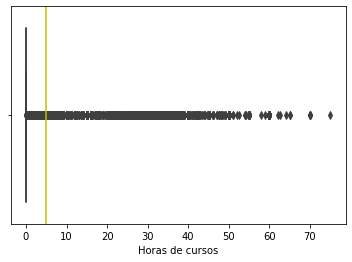

In [43]:
sns.boxplot(x=df['HraCursos_S']);
plt.axvline(df['HraCursos_S'].mean(), c='y');
plt.xlabel("Horas de cursos");

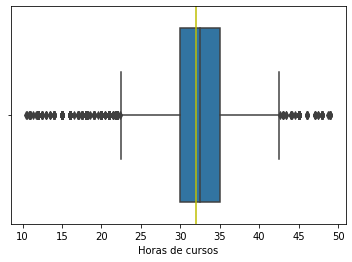

In [52]:
df_filtrado = filtrar(df, 'HraCursos_S');
sns.boxplot(x=df_filtrado['HraCursos_S']);
plt.axvline(df_filtrado['HraCursos_S'].mean(), c='y');
plt.xlabel("Horas de cursos");

In [53]:
segmentos = pd.cut(df_filtrado['HraCursos_S'], 10)

cc = df_filtrado['HraCursos_S'].groupby(segmentos).count()
cc

HraCursos_S
(10.381, 14.278]     125
(14.278, 18.136]     322
(18.136, 21.994]     476
(21.994, 25.852]    1024
(25.852, 29.71]      354
(29.71, 33.568]     3174
(33.568, 37.426]    2944
(37.426, 41.284]    1731
(41.284, 45.142]     315
(45.142, 49.0]        43
Name: HraCursos_S, dtype: int64

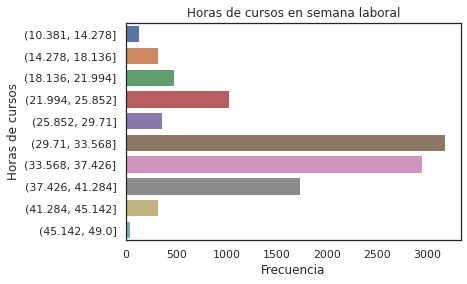

In [54]:
sns.set(style='white');
ax= sns.barplot(x=cc.values,y=cc.index);
ax.set(title='Horas de cursos en semana laboral', xlabel='Frecuencia', ylabel='Horas de cursos');

In [55]:
print(f'Curtosis: {stats.kurtosis(df["HraCursos_S"])}')
print(f'Asimetria: {stats.skew(df["HraCursos_S"])}')

Curtosis: 3.1510996607605195
Asimetria: 2.166160759279892


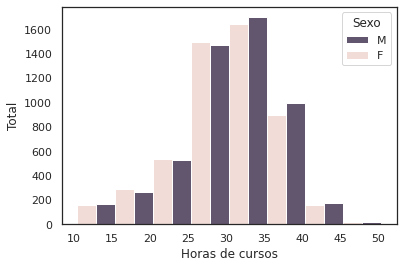

In [58]:
sns.histplot(df_filtrado, x=df_filtrado['HraCursos_S'],binwidth=5,hue=df_filtrado['Sexo'], multiple="dodge");
plt.legend(title='Sexo', loc='upper right', labels=['M', 'F']);
plt.xlabel("Horas de cursos");
plt.ylabel("Total");

In [ ]:
df['Sexo'].value_counts()

2    37898
1    33506
Name: Sexo, dtype: int64

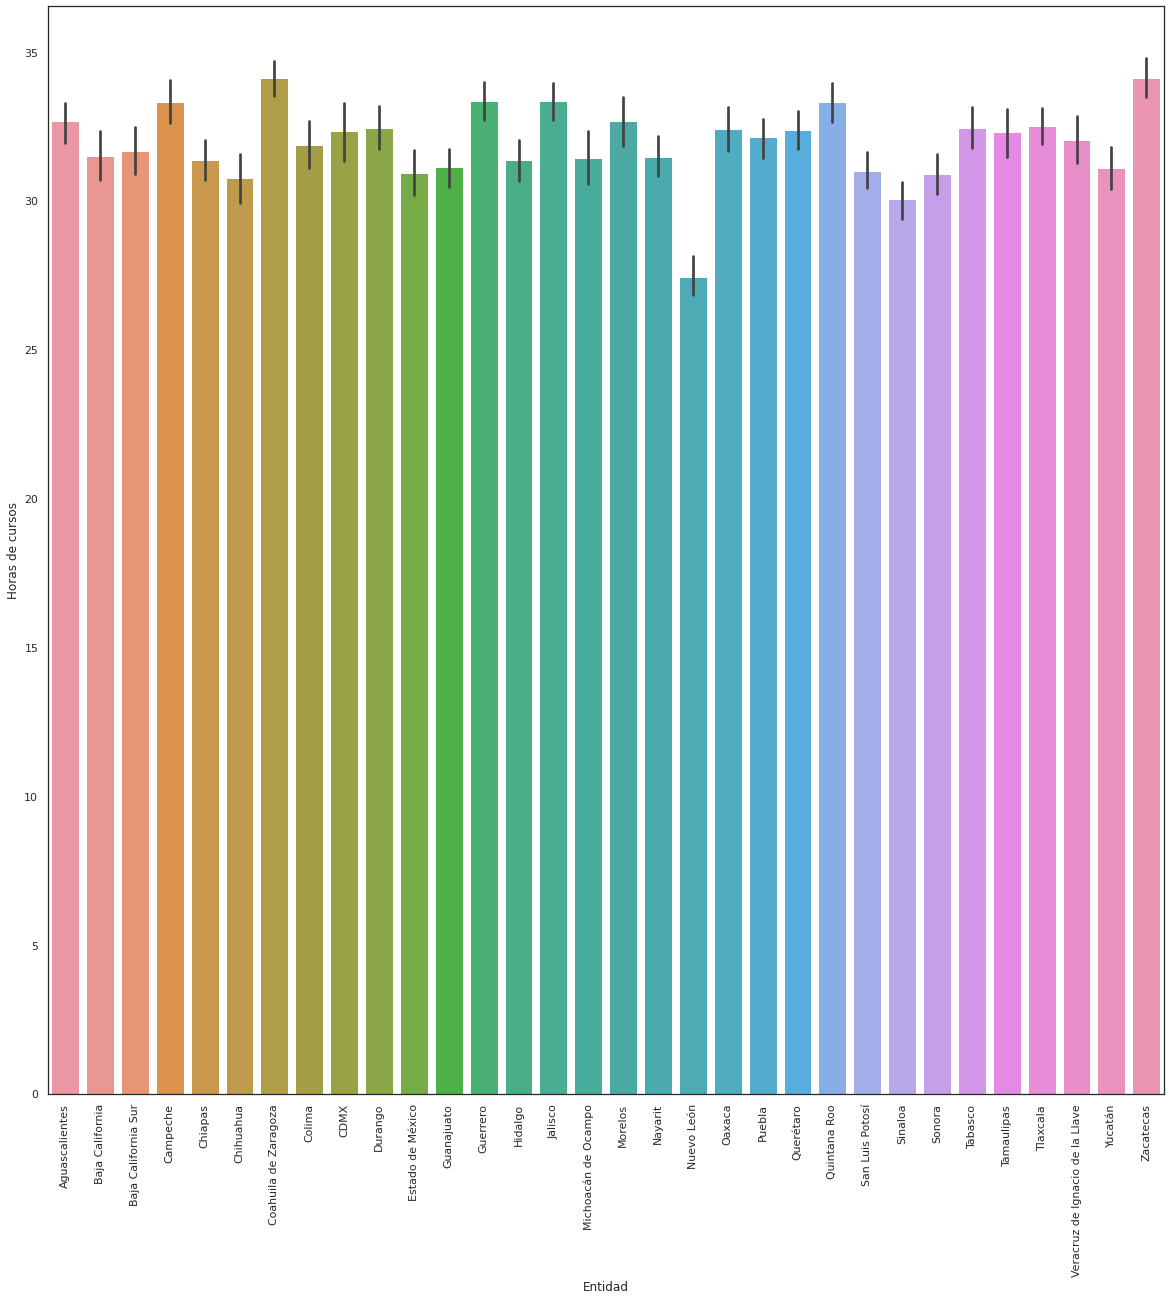

In [60]:
fig = plt.figure(figsize=(20,20));
sns.barplot(x=df_filtrado['Nombre'],y=df_filtrado['HraCursos_S']);
plt.xlabel("Entidad")
plt.ylabel("Horas de cursos")
plt.xticks(rotation=90);

<h3>Analisis de variable Horas de cursos por semana laboral</h3>




In [66]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 200

In [67]:
df_filtrado.isnull().sum(axis = 0)

Entidad         0
Tamaño          0
Sexo            0
Edad            0
Nivel           0
Grado           0
EdoCivil        0
Trabaja         0
HraTrab_S       0
HraTrab_F       0
HraTrasl_S      0
HraTrasl_F      0
HraDorm_S       0
HraDorm_F       0
HraComida_S     0
HraComida_F     0
HraAseoP_S      0
HraAseoP_F      0
Cursos          0
HraCursos_S     0
HraCursos_F     0
Tareas          0
HraTarea_S      0
HraTarea_F      0
TraslEsc        0
HraTrasEsc_S    0
MinTrasEsc_S    0
HraTrasEsc_F    0
MinTrasEsc_F    0
Cocinar         0
HraCoc_S        0
HraCoc_F        0
Trastes         0
HraTraste_S     0
HraTraste_F     0
Barrer          0
HraBarre_S      0
HraBarre_F      0
Jardin          0
HraJard_S       0
HraJard_F       0
Lavar           0
HraLavar_S      0
HraLavar_F      0
Despensa        0
HraDesp_S       0
HraDesp_F       0
Tramites        0
HraTramit_S     0
HraTramit_F     0
Altruis1        0
HraAltr1_S      0
HraAltr1_F      0
Deporte         0
HraDepor_S      0
HraDepor_F

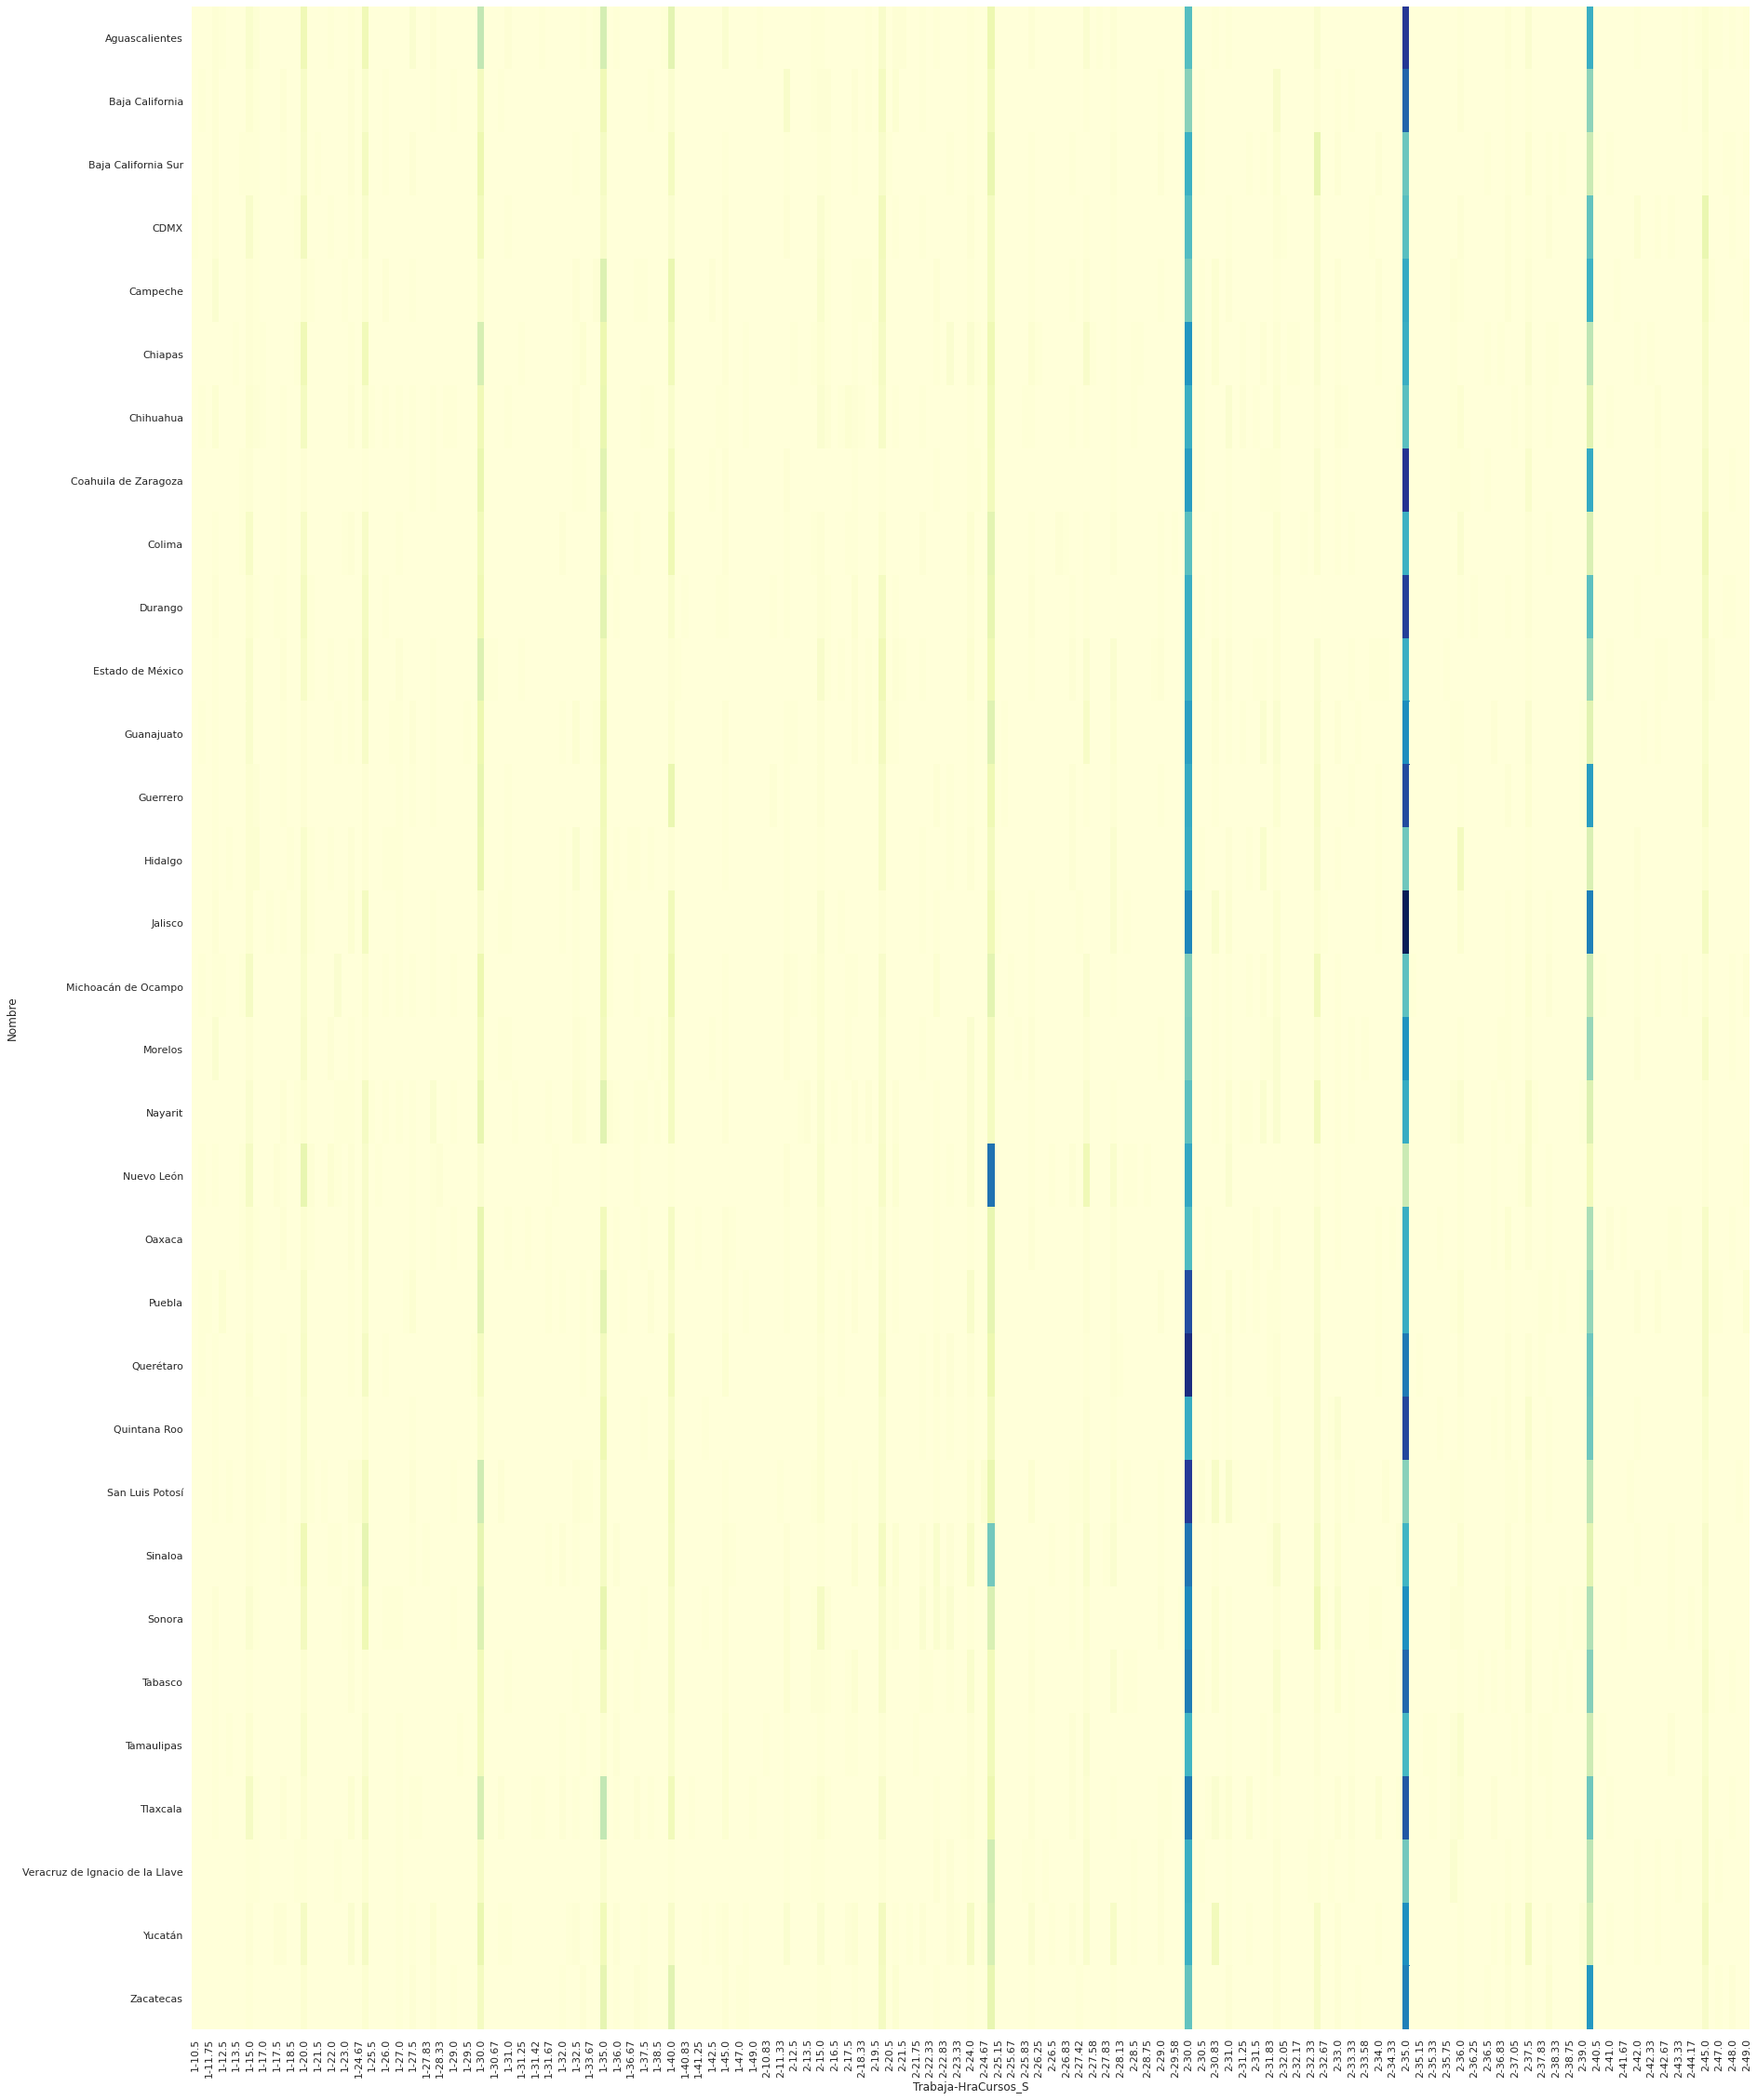

In [82]:
crosstab = pd.crosstab(df['Nombre'], [df['Trabaja'],df['HraCursos_S']]).fillna(0)
fig = plt.figure(figsize=(30,40));
sns.heatmap(crosstab,cmap="YlGnBu", cbar=False);

In [83]:
pd.options.display.max_rows = 999
df.groupby(['Nombre','Trabaja'])['HraCursos_S'].mean()


Nombre                           Trabaja
Aguascalientes                   1          30.161538
                                 2          33.810909
Baja California                  1          27.487818
                                 2          32.450340
Baja California Sur              1          28.688525
                                 2          32.500000
CDMX                             1          25.990385
                                 2          33.743830
Campeche                         1          32.323944
                                 2          33.611255
Chiapas                          1          29.728022
                                 2          31.924708
Chihuahua                        1          28.447368
                                 2          31.598066
Coahuila de Zaragoza             1          32.550847
                                 2          34.421875
Colima                           1          29.919870
                                 2       

<h3>Matriz de correlación</h3>

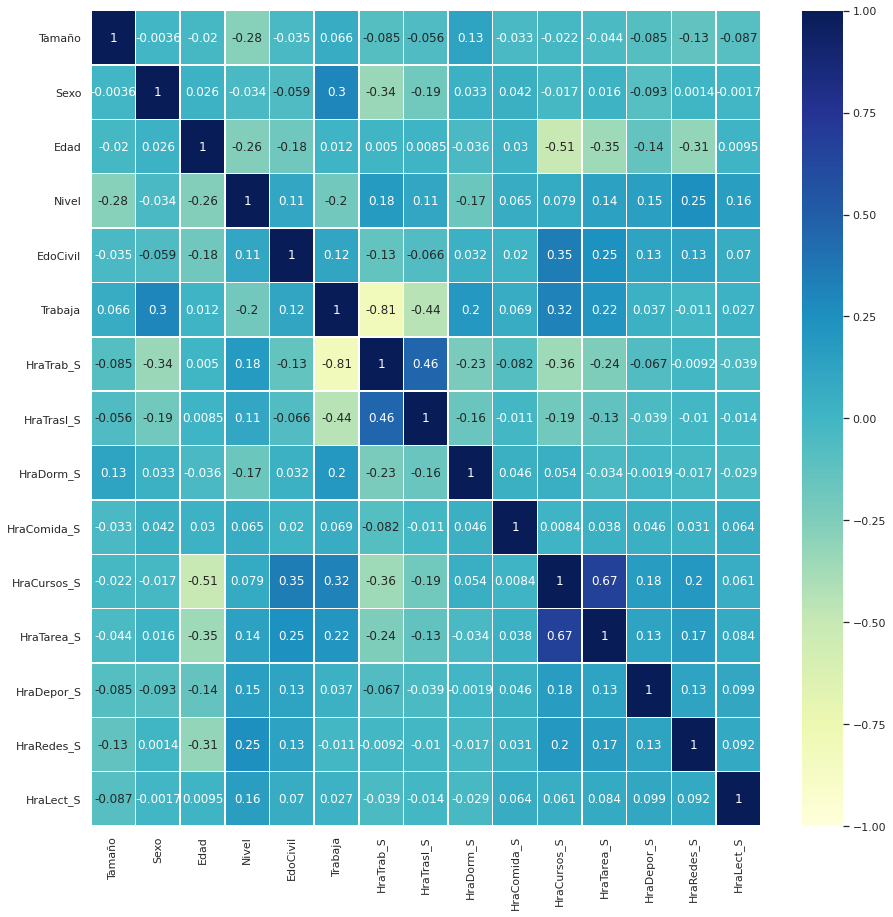

In [ ]:
df_filtered = df[['Nombre','Tamaño','Sexo','Edad','Nivel','EdoCivil','Trabaja','HraTrab_S','HraTrasl_S','HraDorm_S','HraComida_S','HraCursos_S','HraTarea_S','HraDepor_S','HraRedes_S','HraLect_S']]
df_filtered.corr()

plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_filtered.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

<h3>Regresión lineal</h3>

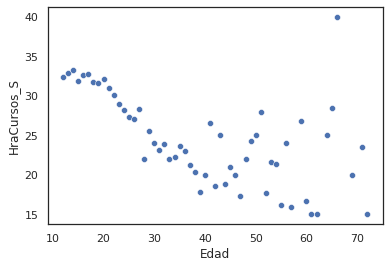

In [88]:
p = df.groupby('Edad')[['Edad','HraCursos_S']].mean();
sns.scatterplot(x=p['Edad'],y=p['HraCursos_S']);

y = -0.19496952254138517 * x + 32.24936362745055
R2: 0.334530154200245


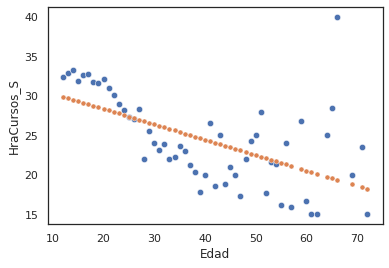

In [89]:
#regresion lineal

lr = LinearRegression()

lr.fit(p['Edad'].to_frame(), p['HraCursos_S'])
y_predict = lr.predict((p['Edad'].to_frame()))
sns.scatterplot(x=p['Edad'], y=p['HraCursos_S'], s=40);
sns.scatterplot(x=p['Edad'], y=y_predict, s=25);
intercept = lr.intercept_
coefficient = lr.coef_[0]
print(f'y = {coefficient} * x + {intercept}')
print(f'R2: {lr.score( p["Edad"].to_frame(), p["HraCursos_S"])}')

<h3>Analisis de rutinas</h3>

In [ ]:
filtrar(df,'HraTrab_S')
tabla = df_filtrado.groupby('Nombre', as_index=False).mean()[['HraTrab_S', 'HraTrasl_S', 'HraDorm_S', 'HraCursos_S' ]]

In [ ]:
nombres = df_filtrado['Nombre'].unique()

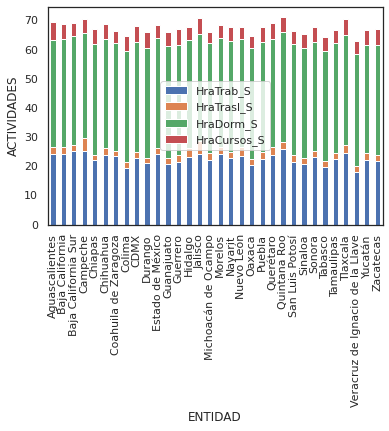

In [ ]:
plot = tabla.plot.bar(stacked=True);
plot.set_xticklabels(nombres,rotation=90);

plot.set_xlabel("ENTIDAD");
plot.set_ylabel("ACTIVIDADES");

<h3>Mapa cloropletico</h3>

In [100]:
df.groupby(["Nombre","Entidad"])["HraCursos_S"].agg('sum')

Nombre                           Entidad
Aguascalientes                   1          13590.92
Baja California                  2           9137.66
Baja California Sur              3           8835.00
CDMX                             9           9281.30
Campeche                         4          10596.98
Chiapas                          5          10909.90
Chihuahua                        6           8860.79
Coahuila de Zaragoza             7          11834.00
Colima                           8           9242.99
Durango                          10         11383.91
Estado de México                 11         10047.83
Guanajuato                       12          9838.43
Guerrero                         13         11906.66
Hidalgo                          14          8245.35
Jalisco                          15         13509.03
Michoacán de Ocampo              16          8894.35
Morelos                          17          9119.15
Nayarit                          18          9914.42
Nuevo

In [108]:
geoj = f'/content/drive/MyDrive/BEDUPrototype/horascursos.json'
m = folium.Map(location=[28, -104], zoom_start=3)

folium.Choropleth(
    geo_data=geoj,
    name='Cloropeta',
    data=df,
    columns=['Nombre', 'HraCursos_S'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    legend_name='Hras Cursos'
).add_to(m)

folium.LayerControl().add_to(m)

m

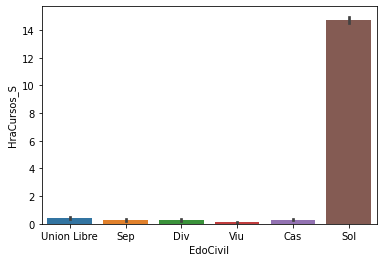

In [39]:
g = sns.barplot(x=df3["EdoCivil"],y=df3["HraCursos_S"]);
g.set_xticklabels(["Union Libre","Sep","Div","Viu","Cas","Sol"]);

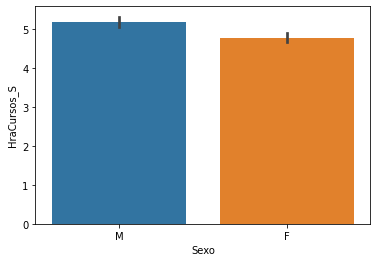

In [43]:
g = sns.barplot(x=df3["Sexo"],y=df3["HraCursos_S"]);
g.set_xticklabels(["M","F"]);

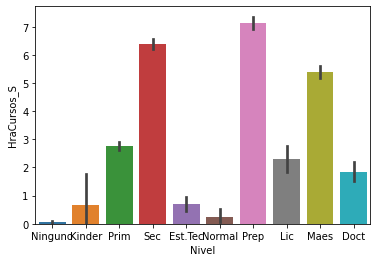

In [44]:
g = sns.barplot(x=df3["Nivel"],y=df3["HraCursos_S"]);
g.set_xticklabels(["Ninguno","Kinder","Prim","Sec","Est.Tec","Normal","Prep","Lic","Maes","Doct"]);

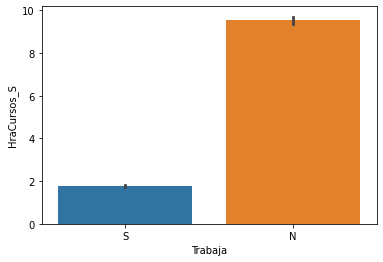

In [45]:
g = sns.barplot(x=df3["Trabaja"],y=df3["HraCursos_S"]);
g.set_xticklabels(["S","N"]);

In [ ]:
pd.set_option('display.max_columns', None)


**DATOS DE ENTRENAMIENTO Y TEST**

In [49]:
X = df3[["Entidad","Tamaño","Sexo","Edad","Nivel","Grado","EdoCivil","Trabaja"]]
y = df3["Cursos"]

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

#**Training**

In [57]:
resultados = dict()
scores_train = dict()

#Regresion Logistica

In [ ]:
modelo = LogisticRegression(solver='lbfgs', max_iter=1000)

In [ ]:
modelo.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
scores = cross_val_score(modelo, X_train, y_train, scoring='neg_mean_absolute_error',cv=10)
scores_train['Logistic'] = 100 + scores.mean()

In [ ]:
scores_rl, score_max, score_min = scores.mean(),scores.max(),scores.min()

#Random Forest

In [ ]:
modelrf = RandomForestClassifier(n_estimators=180)

In [ ]:
modelrf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
scores = cross_val_score(modelrf, X_train, y_train, scoring='neg_mean_absolute_error',cv=10)
scores_train['RandomForest'] = 100 + scores.mean()

#Red Neuronal

In [47]:
modelo_nn = MLPClassifier(hidden_layer_sizes=(16,32),max_iter=200000,activation="logistic",tol=1e-7)

In [52]:
modelo_nn.fit(X,y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=1e-07, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [53]:
scores = cross_val_score(modelo_nn, X_train, y_train, scoring='neg_mean_absolute_error',cv=10)
scores_train['NN'] = 100 + scores.mean()

#SVM

In [ ]:
modelo_svm = SVC()
modelo_svm.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
scores = cross_val_score(modelo_svm, X_train, y_train, scoring='neg_mean_absolute_error',cv=10)
scores_train['SVM'] = 100 + scores.mean()

#Naive-Bayes

In [ ]:
modelNB = GaussianNB()
modelNB.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
scores = cross_val_score(modelNB, X_train, y_train, scoring='neg_mean_absolute_error',cv=10)
scores_train['NaiveBayes'] = 100 + scores.mean()

In [ ]:
print(scores_train)

{'Logistic': 99.92569322988247, 'RandomForest': 99.92721377008495, 'NN': 99.93831775959033, 'SVM': 99.93445638307334, 'NaiveBayes': 99.88683924860202}


#**Testing**

Regresion Logistica

In [ ]:
y_pred = modelo.predict(X_test)

REGRESION LOGISTICA
True positives: 16896
True negatives: 2986
False positives: 963
False negative: 577
Precision:92.81%
Sensibilidad:96.7%
Especificidad:75.61%


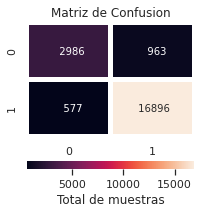

In [ ]:
print(f'REGRESION LOGISTICA')
resultados['regresion'] = scores(y_test,y_pred)

Random Forest

In [ ]:
y_pred = modelrf.predict(X_test)

True positives: 16896
True negatives: 2986
False positives: 963
False negative: 577
Precision:92.81%
Sensibilidad:96.7%
Especificidad:75.61%


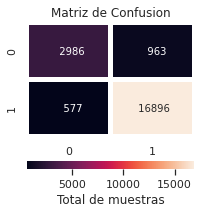

In [ ]:
g = scores(y_test,y_pred)

RANDOM FOREST
True positives: 16896
True negatives: 2986
False positives: 963
False negative: 577
Precision:92.81%
Sensibilidad:96.7%
Especificidad:75.61%


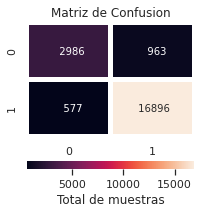

In [ ]:
print(f'RANDOM FOREST')
resultados['random forest'] = scores(y_test,y_pred)

Red Neuronal

In [54]:
y_pred = modelo_nn.predict(X_test)

RED NEURONAL
True positives: 17227
True negatives: 2890
False positives: 964
False negative: 341
Precision:93.91%
Sensibilidad:98.06%
Especificidad:74.99%


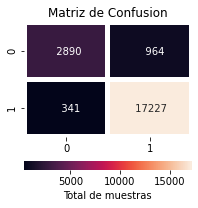

In [61]:
print(f'RED NEURONAL')
resultados['NN'] = scores(y_test,y_pred)

SVM

In [ ]:
y_pred = modelo_svm.predict(X_test)

SUPPORT VECTOR MACHINE
True positives: 16934
True negatives: 3067
False positives: 882
False negative: 539
Precision:93.37%
Sensibilidad:96.92%
Especificidad:77.67%


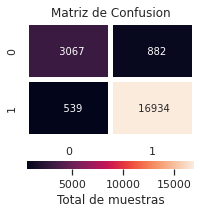

In [ ]:
print(f'SUPPORT VECTOR MACHINE')
resultados['SVM'] = scores(y_test,y_pred)

Naive-Bayes

In [ ]:
y_pred = modelNB.predict(X_test)

NAIVE BAYES
True positives: 15607
True negatives: 3394
False positives: 604
False negative: 1817
Precision:88.7%
Sensibilidad:89.57%
Especificidad:84.89%


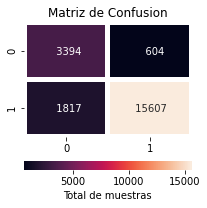

In [ ]:
print(f'NAIVE BAYES')
resultados['NB'] = scores(y_test,y_pred)

#**Evaluacion de testing** 

In [ ]:
print(resultados)

{'regresion': 92.81, 'random forest': 92.81, 'NN': 93.73, 'SVM': 93.37}


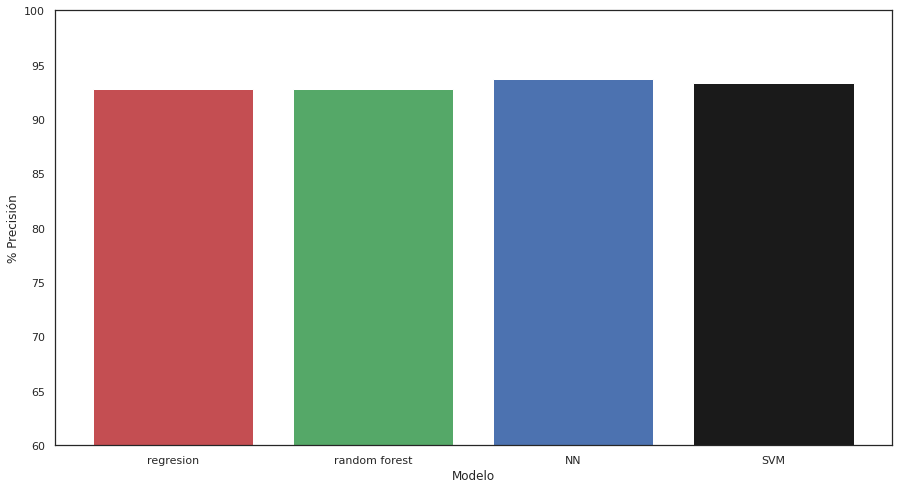

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(range(len(resultados)), list(resultados.values()), align='center',color = list('rgbkymc'));
plt.xticks(range(len(resultados)), list(resultados.keys()));
plt.ylim(60, 100);
plt.xlabel("Modelo");
plt.ylabel("% Precisión");

**Curva de convergencia de los errores del modelo**

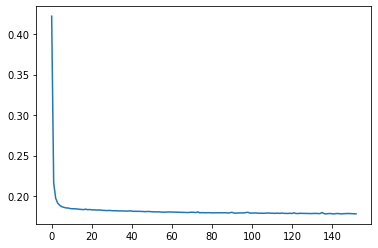

In [62]:
loss_values = modelo_nn.loss_curve_
plt.plot(loss_values)
plt.show()

**MSE**



In [64]:

MSE = mean_squared_error(y_test,y_pred)
print(MSE)

0.06091868172906358


**AUC Score**

In [65]:
from sklearn.metrics import roc_auc_score
f = roc_auc_score(y_test,y_pred)
f


0.8652299866105567

#Prototipo de predictor

In [111]:
entidad = widgets.Dropdown(
    options=[('Aguascalientes',1),
('Baja California',2),
('Baja California Sur',3),
('Campeche',4),
('Coahuila de Zaragoza',5),
('Colima',6),
('Chiapas',7),
('Chihuahua',8),
('Ciudad de México',9),
('Durango',10),
('Guanajuato',11),
('Guerrero',12),
('Hidalgo',13),
('Jalisco',14),
('México',15),
('Michoacán de Ocampo',16),
('Morelos',17),
('Nayarit',18),
('Nuevo León',19),
('Oaxaca',20),
('Puebla',21),
('Querétaro',22),
('Quintana Roo',23),
('San Luis Potosí',24),
('Sinaloa',25),
('Sonora',26),
('Tabasco',27),
('Tamaulipas',28),
('Tlaxcala',29),
('Veracruz de Ignacio de la Llave',30),
('Yucatán',31),
('Zacatecas',32)],
    value=1,
    description='Entidad:'
)

tamaño = widgets.Dropdown(
    options=[('Localidades con 100 000 y más habitantes',1),
('Localidades con una población entre 15 000 y 99 999 habitantes',2),
('Localidades con una población entre 2 500 y 14 999 habitantes',3),
('Localidades con menos de 2 500 habitantes',4)],
    value=1,
    description='Tamaño loc.:',
    layout={'width': 'max-content'}
    
)

sexo = widgets.Dropdown(
    options=[('Masculino',1),
('Femenino',2)],
    value=1,
    description='Sexo:',
    layout={'width': 'max-content'}
    
)

escolaridad = widgets.Dropdown(
    options=[('Ninguno',1),
('Preescolar o kínder',2),
('Primaria',3),
('Estudios técnicos con secundaria terminada',4),
('Normal básica',5),
('Preparatoria o bachillerato',6),
('Estudios técnicos con preparatoria terminada',7),
('Licenciatura o ingeniería (profesional)',8),
('Maestría o doctorado',9)],
    value=1,
    description='Escolaridad:',
    layout={'width': 'max-content'}
    
)

grado = widgets.IntSlider(value=1, max=10,description = 'Grado')
edad = widgets.IntSlider(value=12, max=90,description = 'Edad')



edocivil = widgets.Dropdown(
    options=[('Union Libre',1),
('Separado (a)',2),
('Divorciado (a)',3),
('Viudo (a)',4),
('Casado (a)',5),
('Soltero (a)',6)],
    value=1,
    description='Estado civil:',
    layout={'width': 'max-content'}  
)

actividad = widgets.Dropdown(
    options=[('Trabaja',1),
('Estudia / Ambos',2)],
    value=1,
    description='Actividad:',
    layout={'width': 'max-content'}  
)

widgets.VBox([entidad,tamaño,sexo,edad,escolaridad,grado,edocivil,actividad])

In [166]:
opciones = [entidad.value,tamaño.value,sexo.value,edad.value,escolaridad.value,grado.value,edocivil.value,actividad.value]

In [167]:
predecir(opciones)

La persona o grupo en cuestión NO se interesaría en cursar estudios en una Institución de Enseñanza Superior


*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


-

-

-

-

-

-

-

-

-

-

-

**OPORTUNIDADES DE MERCADO**



*   Actividades deportivas

*   Actividades culturales 

*   Actividades altruistas

*   Reparaciones

*   Servicios de jardineria





** Gracias por su atención